# Data Scientist Project

## Convolutional Neural Networks Application in Dog Identification App 



This notebook intriduces one of the most popular projects using convolutional neural networks. The goal is to classify images of dogs according to their breed. At the end of this project, we will develop an algorithm to accept any user-supplied image as input. Then, estimatea the the dog's breed if a dog is detected in the image.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. In this real-world setting, we will piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.

### The Road Map

This notebook is broken into seprate steps as follows:

* [Step 0](#step0): Load Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds 
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write the Algorithm
* [Step 7](#step7): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


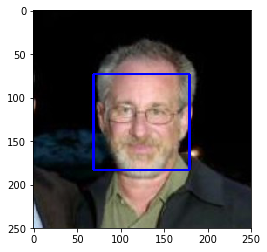

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[7])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [8]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
pred_humanset=[face_detector(x) for x in human_files_short]
pred_dogset=[face_detector(x) for x in dog_files_short]
## on the images in human_files_short and dog_files_short.

print("Percentage of the first 100 images in human_files detected human face? : ", sum(pred_humanset),"%")
print("Percentage of the first 100 images in dog_files detected human face : ", sum(pred_dogset),"%")

Percentage of the first 100 images in human_files detected human face? :  100 %
Percentage of the first 100 images in dog_files detected human face :  11 %


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but  we can try other approaches free.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [11]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [13]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

pred_humanset=[dog_detector(x) for x in human_files_short]
pred_dogset=[dog_detector(x) for x in dog_files_short]


print("Percentage of the first 100 images in human_files detected dog : ", sum(pred_humanset),"%")
print("Percentage of the first 100 images in dog_files detected dog : ", sum(pred_dogset),"%")

Percentage of the first 100 images in human_files detected dog :  0 %
Percentage of the first 100 images in dog_files detected dog :  100 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  we aim to create CNN _from scratch_ (so, we will not use transfer learning in this step !), due to the limited number of trianing images and the proposed shallow CNN, we ail to attain a test accuracy of at least 1%.  In Step 5 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

In this step, we avoid adding too many layers to maintain low computaitonal complexity. More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; we can extrapolate this estimate to figure out how long it will take for our algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  



### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 106.13it/s]


In [15]:
test_tensors.shape

(836, 224, 224, 3)

### Model Architecture
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step. 

__Answer:__ In the proposed CNN architecutre we added convolutional layers and max pooling to extract features from the input image, The number of filters in each step is increased to extract more high level features in mid layers. The last layer is a dense layer that outputs the classification probabilites. 

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,Dense
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Design network architecture
model = Sequential()
model.add(Conv2D(16, (2, 2), padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Conv2D(32, (2, 2), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Conv2D(96, (2, 2), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2), padding='valid'))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 96)        12384     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 96)                0         
__________

### Compile the Model

In [17]:
import keras
# Specify the optimizer
opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train the model in the code cell below.  We use model checkpointing to save the model that attains the best validation loss.


In [18]:
from keras.callbacks import ModelCheckpoint  

# Specify the number of epochs 

epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=50, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 30s 4ms/step - loss: 4.8827 - acc: 0.0087 - val_loss: 4.8668 - val_acc: 0.0156
Epoch 2/20
6680/6680 [==============================] - 29s 4ms/step - loss: 4.8516 - acc: 0.0147 - val_loss: 4.8348 - val_acc: 0.0156
Epoch 3/20
6680/6680 [==============================] - 29s 4ms/step - loss: 4.8036 - acc: 0.0183 - val_loss: 4.8082 - val_acc: 0.0144
Epoch 4/20
6680/6680 [==============================] - 29s 4ms/step - loss: 4.7776 - acc: 0.0175 - val_loss: 4.7847 - val_acc: 0.0156
Epoch 5/20
6680/6680 [==============================] - 29s 4ms/step - loss: 4.7454 - acc: 0.0196 - val_loss: 4.7599 - val_acc: 0.0168
Epoch 6/20
6680/6680 [==============================] - 29s 4ms/step - loss: 4.7165 - acc: 0.0250 - val_loss: 4.7377 - val_acc: 0.0180
Epoch 7/20
6680/6680 [==============================] - 29s 4ms/step - loss: 4.6821 - acc: 0.0275 - val_loss: 4.7182 - val_acc: 0.0251
Epoch 8/

### Load the Model with the Best Validation Loss

In [19]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Lets try out our model on the test dataset of dog images. The accuracy is more than %5.

In [20]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.5024%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we will use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [23]:
# Specify optimizer
opt = keras.optimizers.Adam(lr=0.005)
VGG16_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Train the Model

In [24]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 301us/step - loss: 15.5243 - acc: 0.0320 - val_loss: 15.4860 - val_acc: 0.0371
Epoch 2/20
6680/6680 [==============================] - 2s 251us/step - loss: 15.4336 - acc: 0.0418 - val_loss: 15.4969 - val_acc: 0.0371
Epoch 3/20
6680/6680 [==============================] - 2s 255us/step - loss: 15.4886 - acc: 0.0376 - val_loss: 15.4217 - val_acc: 0.0419
Epoch 4/20
6680/6680 [==============================] - 2s 255us/step - loss: 15.3936 - acc: 0.0442 - val_loss: 15.4173 - val_acc: 0.0431
Epoch 5/20
6680/6680 [==============================] - 2s 253us/step - loss: 15.4014 - acc: 0.0434 - val_loss: 15.4256 - val_acc: 0.0395
Epoch 6/20
6680/6680 [==============================] - 2s 256us/step - loss: 15.4149 - acc: 0.0422 - val_loss: 15.4549 - val_acc: 0.0395
Epoch 7/20
6680/6680 [==============================] - 2s 253us/step - loss: 15.3871 - acc: 0.0449 - val_loss: 15.4938 - val

### Load the Model with the Best Validation Loss

In [25]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [26]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.3062%


### Predict Dog Breed with the Model

In [27]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  It is expected our CNN model attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we use the bottleneck features from the ResNet-50 pre-trained model.  
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features


The files are encoded as such:

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [28]:
# Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

### Model Architecture

Create a CNN to classify dog breed. 
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ we added three dense layers, where the number of neurons in hidden layers are larger than the last layer.



In [29]:
### TODO: Define your architecture.
model = Sequential()

model.add(GlobalAveragePooling2D(input_shape=(1,1,2048)))
model.add(Dense(520, activation='relu'))
model.add(Dense(180, activation='relu'))
model.add(Dense(133, activation='softmax'))


model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 520)               1065480   
_________________________________________________________________
dense_4 (Dense)              (None, 180)               93780     
_________________________________________________________________
dense_5 (Dense)              (None, 133)               24073     
Total params: 1,183,333
Trainable params: 1,183,333
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [30]:
# Specify the optimizer

opt = keras.optimizers.Adam(lr=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model


In [31]:
# Specify number of epoches
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=epochs, batch_size=50, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 228us/step - loss: 2.0554 - acc: 0.5112 - val_loss: 1.0684 - val_acc: 0.6922
Epoch 2/20
6680/6680 [==============================] - 1s 163us/step - loss: 0.5782 - acc: 0.8186 - val_loss: 0.8756 - val_acc: 0.7473
Epoch 3/20
6680/6680 [==============================] - 1s 163us/step - loss: 0.3294 - acc: 0.8961 - val_loss: 0.8352 - val_acc: 0.7581
Epoch 4/20
6680/6680 [==============================] - 1s 163us/step - loss: 0.1965 - acc: 0.9394 - val_loss: 0.7393 - val_acc: 0.7713
Epoch 5/20
6680/6680 [==============================] - 1s 158us/step - loss: 0.1352 - acc: 0.9620 - val_loss: 0.7623 - val_acc: 0.8036
Epoch 6/20
6680/6680 [==============================] - 1s 159us/step - loss: 0.0917 - acc: 0.9738 - val_loss: 0.7416 - val_acc: 0.8072
Epoch 7/20
6680/6680 [==============================] - 1s 165us/step - loss: 0.0547 - acc: 0.9868 - val_loss: 0.6743 - val_acc: 0.8120
E

### Load the Model with the Best Validation Loss

In [32]:
# Load the model weights with the best validation loss.
model.load_weights('saved_models/weights.best.resnet.hdf5')

### Test the Model

Test the model on the test dataset of dog images. The obtained accuracy is higher than 79%.

In [33]:
# get index of predicted dog breed for each image in test set
# dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
dog_breed_predictions = model.predict(test_Inception)
# report test accuracy
test_accuracy = 100*(np.argmax(dog_breed_predictions, axis=1)==np.argmax(test_targets, axis=1)).mean()
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.0670%


### Predict Dog Breed with the Model


In [34]:
def dog_breed_predictor(img_path):
    plt.imshow(img)
    plt.show()
    features =extract_Resnet50(path_to_tensor(train_files[1]))
    predict_vect=model.predict(features)
    dog_name = dog_names[np.argmax(predict_vect)]
    print("Dogs Detected!\nIt looks like a {0}".format(dog_name))  

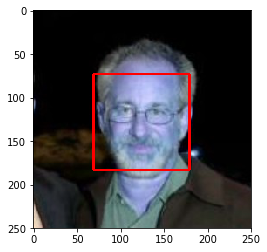

94658560/94653016 [==============================] - 1s 0us/step
Dogs Detected!
It looks like a ages/train/057.Dalmatian


In [35]:
dog_breed_predictor(train_files[1])


---
<a id='step6'></a>
## Step 6: Write your Algorithm

We write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

###  Write your Algorithm

In [36]:
def dog_human_model(img_path):
# read the image 
    img = cv2.imread(img_path)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)
    plt.show()
    if dog_detector(img_path):
        features =extract_Resnet50(path_to_tensor(train_files[1]))
        predict_vect=model.predict(features)
        dog_name = dog_names[np.argmax(predict_vect)]
        print("Dogs Detected!\nIt looks like a {0}".format(dog_name))  
    elif face_detector(img_path):
        features =extract_Resnet50(path_to_tensor(train_files[1]))
        predict_vect=model.predict(features)
        dog_name = dog_names[np.argmax(predict_vect)]
        print("Hello, human!\nIf you were a dog..You may look like a {0}".format(dog_name))
    else:
        print("Error! Can't detect anything..")
        

---
<a id='step7'></a>
## Step 7: Test Your Algorithm


### Test Your Algorithm on Sample Images!

We tested our algorithm on different images. 

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The result showed that our model based on ResNet results in supperior accuracy.

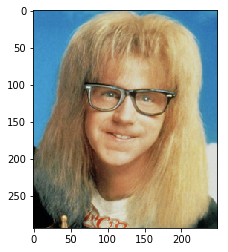

Hello, human!
If you were a dog..You may look like a ages/train/057.Dalmatian


In [37]:
# execute our algorithm from Step 6 on
dog_human_model("/home/workspace/dog-project/images/sample_human_2.png")
